# Data aggregation and group operations

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np

## Grouping data

In [2]:
df = DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                'key2' : ['one', 'two', 'one', 'two', 'one'],
                'data1' : np.random.randn(5),
                'data2' : np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-1.575714,0.827728
1,a,two,-0.401737,0.549935
2,b,one,1.156915,-0.150302
3,b,two,0.826957,-0.126647
4,a,one,-0.569016,-0.101038


Suppose that we want to compute the average of column $data1$ using grouping labels in the column $key1$. A way to do this is to call groupby():

In [3]:
grouped = df['data1'].groupby(df['key1'])
grouped

This grouped variable is now a GroupBy object. It has not actually computed anything yet except for some intermediate data about the group key df['key1'] . The idea is that this object has all of the information needed to then apply some operation to each of the groups. For example, to compute group means we can call the GroupBy’s mean method:

In [4]:
grouped.mean()

key1
a   -0.848823
b    0.991936
Name: data1, dtype: float64

The Series data has been aggregated according to the group key, producing a new Series that is now indexed by the unique values in the key1 column. The result index has the name 'key1' because the DataFrame column df['key1'] did. If instead we had passed multiple arrays as a list, we get something different:

In [5]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one    -1.072365
      two    -0.401737
b     one     1.156915
      two     0.826957
Name: data1, dtype: float64

In this case, we grouped the data using two keys, and the resulting Series now has a hierarchical index consisting of the unique pairs of keys observed:

In [6]:
means.unstack()

key2,one,two
key1,,
a,-1.072365,-0.401737
b,1.156915,0.826957


In these examples, the group keys are all Series, though they could be any arrays of the right length:

In [7]:
countries = np.array( ['Spain', 'France', 'France', 'Spain', 'Spain'] )
years = np.array( [2005, 2005, 2006, 2005, 2006] )
df['data1'].groupby([countries, years]).mean()

France  2005   -0.401737
        2006    1.156915
Spain   2005   -0.374379
        2006   -0.569016
Name: data1, dtype: float64

Frequently the grouping information to be found in the same DataFrame as the data you want to work on. In that case, you can pass column names (whether those are strings, numbers, or other Python objects) as the group keys:

In [8]:
df.groupby('key1').mean( numeric_only=True )

,data1,data2
key1,,
a,-0.848823,0.425541
b,0.991936,-0.138474


In [9]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one  -1.072365  0.363345
     two  -0.401737  0.549935
b    one   1.156915 -0.150302
     two   0.826957 -0.126647

You may have noticed in the first case df.groupby('key1').mean() that there is no key2 column in the result. Because df['key2'] is not numeric data, it is said to be a nuisance column , which is therefore excluded from the result. By default, all of the numeric columns are aggregated, though it is possible to filter down to a subset as we’ll see soon.

Regardless of the objective in using groupby , a generally useful GroupBy method is size(), which returns a Series containing group sizes:

In [10]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

### Iterating over groups

The GroupBy object supports iteration, generating a sequence of 2-tuples containing the group name along with the chunk of data:

In [11]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
  key1 key2     data1     data2
0    a  one -1.575714  0.827728
1    a  two -0.401737  0.549935
4    a  one -0.569016 -0.101038
b
  key1 key2     data1     data2
2    b  one  1.156915 -0.150302
3    b  two  0.826957 -0.126647


In the case of multiple keys, the first element in the tuple will be a tuple of key values:

In [12]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one -1.575714  0.827728
4    a  one -0.569016 -0.101038
('a', 'two')
  key1 key2     data1     data2
1    a  two -0.401737  0.549935
('b', 'one')
  key1 key2     data1     data2
2    b  one  1.156915 -0.150302
('b', 'two')
  key1 key2     data1     data2
3    b  two  0.826957 -0.126647


Of course, you can choose to do whatever you want with the pieces of data. A recipe you may find useful is computing a dict of the data pieces as a one-liner:

In [13]:
pieces = dict(list(df.groupby('key1')))
pieces['b']

,key1,key2,data1,data2
2,b,one,1.156915,-0.150302
3,b,two,0.826957,-0.126647


By default groupby() groups on axis=0 , but you can group on any of the other axes. For example, we could group the columns of our example $df$ here by $dtype$ like so:

In [14]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [15]:
grouped = df.groupby(df.dtypes, axis=1)
dict(list(grouped))

/tmp/ipykernel_46978/1683989302.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = df.groupby(df.dtypes, axis=1)


{dtype('float64'):       data1     data2
 0 -1.575714  0.827728
 1 -0.401737  0.549935
 2  1.156915 -0.150302
 3  0.826957 -0.126647
 4 -0.569016 -0.101038,
 dtype('O'):   key1 key2
 0    a  one
 1    a  two
 2    b  one
 3    b  two
 4    a  one}

### Selecting a column or subset of columns

Indexing a GroupBy object created from a DataFrame with a column name or array of column names has the effect of selecting those columns for aggregation. This means that:

In [16]:
df.groupby('key1')['data1']

Is syntactic sugar for:

In [17]:
df.data1.groupby( df['key1'] )

Especially for large data sets, it may be desirable to aggregate only a few columns. For example, in the above data set, to compute means for just the data2 column and get the result as a DataFrame, we could write:

In [18]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   0.363345
     two   0.549935
b    one  -0.150302
     two  -0.126647

The object returned by this indexing operation is a grouped DataFrame if a list or array is passed and a grouped Series is just a single column name that is passed as a scalar:

In [19]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped

In [20]:
s_grouped.mean()

key1  key2
a     one     0.363345
      two     0.549935
b     one    -0.150302
      two    -0.126647
Name: data2, dtype: float64

Note the difference between the previous operations. In the first case, we use fancy indexing, obtaining a DataFrame as a result. In the second case we do simple 1D indexing, obtaining a Series object.

### Grouping with dictionaries and Series

Grouping information may exist in a form other than an array. Let’s consider another example:

In [21]:
people = DataFrame(np.random.randn(5, 5),
                   columns=['a', 'b', 'c', 'd', 'e'],
                   index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.iloc[2:3,2:4] = np.nan # Añadimos unos cuantos valores NaN
people

,a,b,c,d,e
Joe,-1.512194,0.804828,-2.499523,1.577934,-0.068658
Steve,1.643566,-0.471421,1.263730,-0.826771,-1.115260
Wes,0.563456,0.648212,NaN,NaN,3.249230
Jim,2.081277,-0.146897,-1.420504,0.206704,1.125124
Travis,-0.098753,-0.597339,-0.130315,-0.175208,-0.534937


Suppose we have a group correspondence for the columns and want to sum together the columns by group:

In [22]:
corresp = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'}

We could easily construct an array from this dict to pass to groupby() ...

In [23]:
array=list(map( corresp.get, sorted(corresp.keys())[:-1] ))
array

['red', 'red', 'blue', 'blue', 'red']

In [24]:
people.groupby( array, axis=1 ).sum()

/tmp/ipykernel_46978/3880233839.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  people.groupby( array, axis=1 ).sum()


,blue,red
Joe,-0.921589,-0.776024
Steve,0.436959,0.056885
Wes,0.000000,4.460899
Jim,-1.213800,3.059504
Travis,-0.305524,-1.231029


But instead we can just pass the dict:

In [25]:
by_column = people.groupby(corresp, axis=1)
by_column.sum()

/tmp/ipykernel_46978/4265104188.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  by_column = people.groupby(corresp, axis=1)


,blue,red
Joe,-0.921589,-0.776024
Steve,0.436959,0.056885
Wes,0.000000,4.460899
Jim,-1.213800,3.059504
Travis,-0.305524,-1.231029


The same functionality holds for Series, which can be viewed as a fixed size mapping:

In [26]:
corr_series = Series(corresp)
corr_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [27]:
people.groupby(corr_series, axis=1).sum()

/tmp/ipykernel_46978/544936180.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  people.groupby(corr_series, axis=1).sum()


,blue,red
Joe,-0.921589,-0.776024
Steve,0.436959,0.056885
Wes,0.000000,4.460899
Jim,-1.213800,3.059504
Travis,-0.305524,-1.231029


### Grouping with functions

Using Python functions in what can be fairly creative ways is a more abstract way of defining a group mapping compared with a dict or Series. Any function passed as a group key will be called once per index value, with the return values being used as the group names. More concretely, consider the example DataFrame from the previous section, which has people’s first names as index values. Suppose you wanted to group by the length of the names:

In [28]:
longs = list(map( len, people.index.values ))
longs

[3, 5, 3, 3, 6]

In [29]:
people.groupby( longs ).count()

,a,b,c,d,e
3,3,3,2,2,3
5,1,1,1,1,1
6,1,1,1,1,1


Instead of computing lengths by hand to pass to groupby(), we can just pass len() as grouping key:

In [30]:
people.groupby( len ).count()

,a,b,c,d,e
3,3,3,2,2,3
5,1,1,1,1,1
6,1,1,1,1,1


Mixing functions with arrays, dicts, or Series is not a problem as everything gets converted to arrays internally:

In [31]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -1.512194  0.648212 -2.499523  1.577934 -0.068658
  two  2.081277 -0.146897 -1.420504  0.206704  1.125124
5 one  1.643566 -0.471421  1.263730 -0.826771 -1.115260
6 two -0.098753 -0.597339 -0.130315 -0.175208 -0.534937

### Grouping by index levels

A final convenience for hierarchically-indexed data sets is the ability to aggregate using one of the levels of an axis index. To do this, pass the level number or name using the $level$ keyword:

In [32]:
columns = pd.MultiIndex.from_arrays([['ES', 'ES', 'ES', 'FR', 'FR'],
                                    [1, 3, 4, 1, 3]], names=['qty', 'quarter'])
hier_df = DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

qty            ES                            FR          
quarter         1         3         4         1         3
0        0.975959  0.972724  0.161930 -0.475592 -0.055807
1       -0.061728  1.343248  1.369373  1.401480  0.233072
2       -1.214610  0.824518  0.620550  1.034417 -1.594007
3       -3.133646  1.606213 -0.571594 -1.563751  0.412575

In [33]:
hier_df.groupby(level='qty', axis=1).count()

/tmp/ipykernel_46978/2814642410.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  hier_df.groupby(level='qty', axis=1).count()


qty,ES,FR
0,3,2
1,3,2
2,3,2
3,3,2


## Data aggregation

Recall tat quantile() computes sample quantiles of a Series or a DataFrame’s columns:

In [34]:
df

,key1,key2,data1,data2
0,a,one,-1.575714,0.827728
1,a,two,-0.401737,0.549935
2,b,one,1.156915,-0.150302
3,b,two,0.826957,-0.126647
4,a,one,-0.569016,-0.101038


In [35]:
grouped = df.groupby('key1')
grouped['data1'].quantile(0.9)

key1
a   -0.435193
b    1.123919
Name: data1, dtype: float64

While quantile is not explicitly implemented for GroupBy, it is a Series method and thus available for use. Internally, GroupBy efficiently slices up the Series, calls piece.quantile(0.9) for each piece, then assembles those results together into the result object. 

To use your own aggregation functions, pass any function that aggregates an array to the aggregate or agg method:

In [36]:
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped[['data1','data2']].agg(peak_to_peak) # Select numeric columns only

,data1,data2
key1,,
a,1.173977,0.928766
b,0.329959,0.023655


You’ll notice that some methods like describe() also work, even though they are not aggregations, strictly speaking:

In [37]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0 -0.848823  0.635039 -1.575714 -1.072365 -0.569016 -0.485377   
b      2.0  0.991936  0.233316  0.826957  0.909446  0.991936  1.074425   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a    -0.401737   3.0  0.425541  0.476715 -0.101038  0.224448  0.549935   
b     1.156915   2.0 -0.138474  0.016726 -0.150302 -0.144388 -0.138474   

                          
           75%       max  
key1                      
a     0.688831  0.827728  
b    -0.132561 -0.126647

Internally, these functions are being invoked through apply(), which we will cover later.

User-defined aggregation functions are slower than built-in ones:

In [38]:
%timeit grouped[['data1','data2']].agg(peak_to_peak)

1.48 ms ± 24.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [39]:
%timeit grouped.sum()

84.2 μs ± 3.38 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


This happens because many functions have been reimplemented and optimized in GroupBy, while user-defined functions need to be treated in a conservative way.

### Column-wise and multiple function application

Let's go over a more complex aggregation example. The $reshape2$ package from R includes a dataset on restaurant tipping. We load it from the CSV file:

In [40]:
tips = pd.read_csv('Files-09/tips.csv')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


We add a $tip\_pct$ column to represent the percentage of the tip with respect to the total bill:

In [41]:
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


You may want to aggregate using a different function depending on the column or multiple functions at once. First, let's group the tips by $sex$ and $smoker$:

In [42]:
grouped = tips.groupby(['sex', 'smoker'])
grouped_pct = grouped.tip_pct
grouped_pct.agg( 'mean' ) # We can provide standard function names to agg()

sex     smoker
Female  No        0.156921
        Yes       0.182150
Male    No        0.160669
        Yes       0.152771
Name: tip_pct, dtype: float64

If we call agg() providing a list of functions, we get a DataFrame with the values resulting from aggregating using each of them:

In [43]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
sex    smoker                                  
Female No      0.156921  0.036421      0.195876
       Yes     0.182150  0.071595      0.360233
Male   No      0.160669  0.041849      0.220186
       Yes     0.152771  0.090588      0.674707

By default, agg() uses the function names for the resulting columns, but this can be configured. This is specially useful due to the impossibility of using more than one lambda function:

In [44]:
# grouped_pct.agg( [lambda x: max(x), lambda x: min(x)] )
#---------------------------------------------------------------------------
#SpecificationError                        Traceback (most recent call last)
#<ipython-input-117-8f93d468d44b> in <module>()
#----> 1 grouped_pct.agg( [lambda x: max(x), lambda x: min(x)] )
#
#/usr/lib/python2.7/site-packages/pandas/core/groupby.pyc in agg(self, func, *args, **kwargs)
#    679     @Appender(_agg_doc)
#    680     def agg(self, func, *args, **kwargs):
#--> 681         return self.aggregate(func, *args, **kwargs)
#    682 
#    683     def _iterate_slices(self):
#
#/usr/lib/python2.7/site-packages/pandas/core/groupby.pyc in aggregate(self, func_or_funcs, *args, **kwargs)
#   2304 
#   2305         if hasattr(func_or_funcs, '__iter__'):
#-> 2306             ret = self._aggregate_multiple_funcs(func_or_funcs)
#   2307         else:
#   2308             cyfunc = _intercept_cython(func_or_funcs)
#
#/usr/lib/python2.7/site-packages/pandas/core/groupby.pyc in _aggregate_multiple_funcs(self, arg)
#   2351             if name in results:
#   2352                 raise SpecificationError('Function names must be unique, '
#-> 2353                                          'found multiple named %s' % name)
#   2354 
#   2355             results[name] = self.aggregate(func)
#
#SpecificationError: Function names must be unique, found multiple named <lambda>

In order to solve this problem, we can provide functions as 2-tuples containing a pair (name, function):

In [45]:
grouped_pct.agg( [('max', lambda x: max(x)), ('min', lambda x: min(x))] )

max       min
sex    smoker                    
Female No      0.252672  0.056797
       Yes     0.416667  0.056433
Male   No      0.291990  0.071804
       Yes     0.710345  0.035638

Working on a DataFrame the possibilities increase, as we can specify either a list of functions to apply to all columns, or a different list of functions for each individual column:

In [46]:
functions = ['count', 'mean', 'max']
result = grouped[['tip_pct', 'total_bill']].agg(functions)
result

tip_pct                     total_bill                  
                count      mean       max      count       mean    max
sex    smoker                                                         
Female No          54  0.156921  0.252672         54  18.105185  35.83
       Yes         33  0.182150  0.416667         33  17.977879  44.30
Male   No          97  0.160669  0.291990         97  19.791237  48.33
       Yes         60  0.152771  0.710345         60  22.284500  50.81

The resulting table uses hierarchical columns. As before, we can provide a list of 2-tuples of the form (name, function):

In [47]:
ftuples = [('mean', 'mean'), ('variance', np.var)]
grouped[['tip_pct', 'total_bill']].agg(ftuples)

/tmp/ipykernel_46978/2937199838.py:2: FutureWarning: The provided callable <function var at 0x7f10109baf20> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  grouped[['tip_pct', 'total_bill']].agg(ftuples)


tip_pct           total_bill           
                   mean  variance       mean   variance
sex    smoker                                          
Female No      0.156921  0.001327  18.105185  53.092422
       Yes     0.182150  0.005126  17.977879  84.451517
Male   No      0.160669  0.001751  19.791237  76.152961
       Yes     0.152771  0.008206  22.284500  98.244673

If we want to apply different functions to each column we pass a dictionary containing the correspondence between each column and the list of functions to apply:

In [48]:
grouped.agg({'tip' : np.max, 'size' : 'sum'})

/tmp/ipykernel_46978/683326323.py:1: FutureWarning: The provided callable <function max at 0x7f10109ba2a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  grouped.agg({'tip' : np.max, 'size' : 'sum'})


tip  size
sex    smoker            
Female No       5.2   140
       Yes      6.5    74
Male   No       9.0   263
       Yes     10.0   150

In [49]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

tip_pct                               size
                    min       max      mean       std  sum
sex    smoker                                             
Female No      0.056797  0.252672  0.156921  0.036421  140
       Yes     0.056433  0.416667  0.182150  0.071595   74
Male   No      0.071804  0.291990  0.160669  0.041849  263
       Yes     0.035638  0.710345  0.152771  0.090588  150

Note how hierarchical columns are only used in the resulting table if more than one function is applied to a column.

## Group-wise operations and transformations

Suppose we wanted to add columns to the tips DataFrame containing group means for each index. One way to do this is to aggregate, then merge:

In [50]:
means = tips.groupby( ["sex", "smoker"] ).mean( numeric_only=True )
tips.merge( means, left_on=["sex", "smoker"], right_index=True, suffixes=["","_mean"] )

,total_bill,tip,sex,smoker,day,time,size,tip_pct,total_bill_mean,tip_mean,size_mean,tip_pct_mean
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447,18.105185,2.773519,2.592593,0.156921
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542,19.791237,3.113402,2.711340,0.160669
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587,19.791237,3.113402,2.711340,0.160669
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780,19.791237,3.113402,2.711340,0.160669
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808,18.105185,2.773519,2.592593,0.156921
...,...,...,...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,0.203927,19.791237,3.113402,2.711340,0.160669
240,27.18,2.00,Female,Yes,Sat,Dinner,2,0.073584,17.977879,2.931515,2.242424,0.182150
241,22.67,2.00,Male,Yes,Sat,Dinner,2,0.088222,22.284500,3.051167,2.500000,0.152771
242,17.82,1.75,Male,No,Sat,Dinner,2,0.098204,19.791237,3.113402,2.711340,0.160669


This works, but is somewhat inflexible. You can think of the operation as transforming the two data columns using the np.mean() function. We could use any other built-in function, but if we wanted to apply a user-defined function to each column, we would be in trouble. One function that allows us to apply arbitrary functions to grouped data is GroupBy.transform(), which works at the column level:

In [51]:
def demean(arr):
    return arr - arr.mean()
demeaned = tips.groupby(["sex","smoker"])[['total_bill','tip','size','tip_pct']].transform( demean )
demeaned

,total_bill,tip,size,tip_pct
0,-1.115185,-1.763519,-0.592593,-0.097474
1,-9.451237,-1.453402,0.288660,-0.000127
2,1.218763,0.386598,0.288660,0.005919
3,3.888763,0.196598,-0.711340,-0.020888
4,6.484815,0.836481,1.407407,-0.010113
...,...,...,...,...
239,9.238763,2.806598,0.288660,0.043258
240,9.202121,-0.931515,-0.242424,-0.108567
241,0.385500,-1.051167,-0.500000,-0.064549
242,-1.971237,-1.363402,-0.711340,-0.062464


As you can see, transform() has applied a function to each group, and has aligned the results using the original indices to produce the final result. We could have also used a function producing a scalar result:

In [52]:
tips.groupby( ["sex", "smoker"] ).transform( "mean", numeric_only=True )

,total_bill,tip,size,tip_pct
0,18.105185,2.773519,2.592593,0.156921
1,19.791237,3.113402,2.711340,0.160669
2,19.791237,3.113402,2.711340,0.160669
3,19.791237,3.113402,2.711340,0.160669
4,18.105185,2.773519,2.592593,0.156921
...,...,...,...,...
239,19.791237,3.113402,2.711340,0.160669
240,17.977879,2.931515,2.242424,0.182150
241,22.284500,3.051167,2.500000,0.152771
242,19.791237,3.113402,2.711340,0.160669


In this case, the scalar result of "mean" has been unpacked and broadcasted over the elements of each group.

### apply(): general *split-apply-combine*

Like aggregate , transform is a more specialized function having rigid requirements: the passed function must either produce a scalar value to be broadcasted, like np.mean(), or a transformed array of the same size. The most general purpose GroupBy method is apply(). It splits the object being manipulated into pieces, invokes the passed function on each piece, then attempts to concatenate the pieces together. Suppose we want to select the top five $tip_pct$ values by group:

In [53]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]
top(tips)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


If we group by $smoker$ and call apply() with this function:

In [54]:
tips.groupby('smoker').apply(top)

/tmp/ipykernel_46978/1695234324.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tips.groupby('smoker').apply(top)


total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

The top function is called on each piece of the DataFrame, then the results are glued together using pandas.concat(), labeling the pieces with the group names. The result therefore has a hierarchical index whose inner level contains index values from the original DataFrame. 

If you pass a function to apply() that takes other arguments or keywords, you can pass these after the function:

In [55]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

/tmp/ipykernel_46978/4096842605.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')


total_bill    tip     sex smoker   day    time  size  \
smoker day                                                              
No     Fri  94        22.75   3.25  Female     No   Fri  Dinner     2   
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4   
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6   
       Thur 142       41.19   5.00    Male     No  Thur   Lunch     5   
Yes    Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4   
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3   
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3   
       Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4   

                  tip_pct  
smoker day                 
No     Fri  94   0.142857  
       Sat  212  0.186220  
       Sun  156  0.103799  
       Thur 142  0.121389  
Yes    Fri  95   0.117750  
       Sat  170  0.196812  
       Sun  182  0.077178  
       Thur 197  0.115982

It is possible to remove group keys from the result:

In [56]:
tips.groupby('smoker', group_keys=False).apply(top)

/tmp/ipykernel_46978/1502793219.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tips.groupby('smoker', group_keys=False).apply(top)


,total_bill,tip,sex,smoker,day,time,size,tip_pct
88,24.71,5.85,Male,No,Thur,Lunch,2,0.236746
185,20.69,5.00,Male,No,Sun,Dinner,5,0.241663
51,10.29,2.60,Female,No,Sun,Dinner,2,0.252672
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


### Example: quantile and bucket analysis

As you may recall, pandas has some tools, in particular cut() and qcut(), for slicing data up into buckets with bins of your choosing or by sample quantiles. Combining these functions with groupby() it becomes very simple to set and an equal-length bucket categorization using cut():

In [57]:
frame = DataFrame({'data1': np.random.randn(1000),
                   'data2': np.random.randn(1000)})
factor = pd.cut(frame.data1, 4)
factor[:10]

0       (1.42, 3.033]
1    (-1.805, -0.192]
2      (-0.192, 1.42]
3      (-0.192, 1.42]
4      (-0.192, 1.42]
5      (-0.192, 1.42]
6      (-0.192, 1.42]
7    (-1.805, -0.192]
8    (-1.805, -0.192]
9       (1.42, 3.033]
Name: data1, dtype: category
Categories (4, interval[float64, right]): [(-3.424, -1.805] < (-1.805, -0.192] < (-0.192, 1.42] < (1.42, 3.033]]

The Factor object returned by cut() can be passed directly to groupby(), so we could compute a set of statistics for the $data2$ column like so:

In [58]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

grouped = frame.data2.groupby(factor)
grouped.apply(get_stats).unstack()

/tmp/ipykernel_46978/3759569901.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = frame.data2.groupby(factor)


,min,max,count,mean
data1,,,,
"(-3.424, -1.805]",-1.871725,2.325792,37.0,0.028903
"(-1.805, -0.192]",-2.502974,2.984483,387.0,0.047721
"(-0.192, 1.42]",-3.365410,3.836649,506.0,0.048446
"(1.42, 3.033]",-1.998610,1.761535,70.0,0.166715


### Example: filling missing values with group-specific values

In [59]:
s = Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1    0.608520
2         NaN
3    0.265630
4         NaN
5   -1.697739
dtype: float64

We have studied how to use fillna() to fill missing values in a dataset:

In [60]:
s.fillna(s.mean())

0   -0.274530
1    0.608520
2   -0.274530
3    0.265630
4   -0.274530
5   -1.697739
dtype: float64

Suppose that the filling value must vary depending on each row of data. We only need to group them and call apply() to use fillna() on each group:

In [61]:
countries = ['Spain', 'Portugal', 'France', 'Albania', 'Greece', 'Romania', 'Slovenia']
group_keys = ['West'] * 3 + ['East'] * 4
data = Series( np.random.randn( 7 ), index=countries )
data[ ['France', 'Romania'] ] = np.nan
data

Spain       0.365868
Portugal    0.997408
France           NaN
Albania    -0.551895
Greece      1.758597
Romania          NaN
Slovenia   -1.747155
dtype: float64

Podemos rellenar los valores ausentes usando la media de cada grupo:

In [62]:
data.groupby(group_keys).mean()

East   -0.180151
West    0.681638
dtype: float64

In [63]:
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_keys).apply(fill_mean)

East  Albania    -0.551895
      Greece      1.758597
      Romania    -0.180151
      Slovenia   -1.747155
West  Spain       0.365868
      Portugal    0.997408
      France      0.681638
dtype: float64

We could also have used fixed, predefined values for each group:

In [64]:
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])
data.groupby(group_keys).apply(fill_func)

East  Albania    -0.551895
      Greece      1.758597
      Romania     0.500000
      Slovenia   -1.747155
West  Spain       0.365868
      Portugal    0.997408
      France     -1.000000
dtype: float64

## Pivot tables and cross-tabulation

A pivot table is a data summarization tool frequently found in spreadsheet programs and other data analysis software. It aggregates a table of data by one or more keys, arranging the data in a rectangle with some of the group keys along the rows and some along the columns. Pivot tables in Python with pandas are made possible using the groupby() facility combined with reshape operations utilizing hierarchical indexing. Pandas provides a higher-level interface through the pivot_table() method.

Returning to the tipping data set, suppose we wanted to compute a table of group means (the default pivot_table() aggregation type) arranged by sex and smoker on the rows:

In [65]:
tips.pivot_table( index=['sex', 'smoker'], values=["total_bill","tip","size","tip_pct"] )

size       tip   tip_pct  total_bill
sex    smoker                                          
Female No      2.592593  2.773519  0.156921   18.105185
       Yes     2.242424  2.931515  0.182150   17.977879
Male   No      2.711340  3.113402  0.160669   19.791237
       Yes     2.500000  3.051167  0.152771   22.284500

This could have been easily produced using groupby(). Now, suppose we want to aggregate only $tip\_pct$ and $size$, and additionally group by $day$. We’ll put $smoker$ in the table columns and $day$ in the rows:

In [66]:
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'smoker'], columns='day')

size                                 tip_pct            \
day              Fri       Sat       Sun      Thur       Fri       Sat   
sex    smoker                                                            
Female No      2.500  2.307692  3.071429  2.480000  0.165296  0.147993   
       Yes     2.000  2.200000  2.500000  2.428571  0.209129  0.163817   
Male   No      2.000  2.656250  2.883721  2.500000  0.138005  0.162132   
       Yes     2.125  2.629630  2.600000  2.300000  0.144730  0.139067   

                                   
day                 Sun      Thur  
sex    smoker                      
Female No      0.165710  0.155971  
       Yes     0.237075  0.163073  
Male   No      0.158291  0.165706  
       Yes     0.173964  0.164417

We can add a row and column to compute the partial totals using $margins$:

In [67]:
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'smoker'], columns='day', margins=True)

size                                           tip_pct  \
day                 Fri       Sat       Sun      Thur       All       Fri   
sex    smoker                                                               
Female No      2.500000  2.307692  3.071429  2.480000  2.592593  0.165296   
       Yes     2.000000  2.200000  2.500000  2.428571  2.242424  0.209129   
Male   No      2.000000  2.656250  2.883721  2.500000  2.711340  0.138005   
       Yes     2.125000  2.629630  2.600000  2.300000  2.500000  0.144730   
All            2.105263  2.517241  2.842105  2.451613  2.569672  0.169913   

                                                       
day                 Sat       Sun      Thur       All  
sex    smoker                                          
Female No      0.147993  0.165710  0.155971  0.156921  
       Yes     0.163817  0.237075  0.163073  0.182150  
Male   No      0.162132  0.158291  0.165706  0.160669  
       Yes     0.139067  0.173964  0.164417  0.152771  
All            0.153152  0.166897  0.161276  0.160803

To use a different aggregation function, pass it to $aggfunc$. For example, 'count' or len() will give you a cross-tabulation (count or frequency) of group sizes:

In [68]:
tips.pivot_table('tip_pct', index=['sex', 'smoker'], columns='day', aggfunc=len, margins=True)

day            Fri  Sat  Sun  Thur  All
sex    smoker                          
Female No        2   13   14    25   54
       Yes       7   15    4     7   33
Male   No        2   32   43    20   97
       Yes       8   27   15    10   60
All             19   87   76    62  244

If some combinations are empty (or otherwise NA), you may wish to pass a $fill\_value$:

In [69]:
tips.pivot_table('size', index=['time', 'sex', 'smoker'], columns='day', aggfunc='sum', fill_value=0)

day                   Fri  Sat  Sun  Thur
time   sex    smoker                     
Dinner Female No        2   30   43     2
              Yes       8   33   10     0
       Male   No        4   85  124     0
              Yes      12   71   39     0
Lunch  Female No        3    0    0    60
              Yes       6    0    0    17
       Male   No        0    0    0    50
              Yes       5    0    0    23

### Cross-tabulations: crosstab()

Suppose that we categorize the tips in the tipping dataset as "small" (< 10%), "regular" (between 10 and 20%), or large (>20%):

In [70]:
def tip_size( tip_pct ):
    if tip_pct < 0.10: return "Small"
    elif tip_pct < 0.20: return "Regular"
    return "Large"

tip_size = tips.tip_pct.apply( tip_size )
tip_size

0        Small
1      Regular
2      Regular
3      Regular
4      Regular
        ...   
239      Large
240      Small
241      Small
242      Small
243    Regular
Name: tip_pct, Length: 244, dtype: object

As part of some survey analysis, we might wish to summarize this data by whether the table was a smoker or non-smoker one. The crosstab() function is very convenient in this case:

In [71]:
pd.crosstab( tips.smoker, tip_size, margins=True )

tip_pct,Large,Regular,Small,All
smoker,,,,
No,23,119,9,151
Yes,16,59,18,93
All,39,178,27,244


The first two arguments to crosstab() can be an array or a Series or a list of arrays:

In [72]:
pd.crosstab( [tips.smoker, tips.sex], tip_size, margins=True )

tip_pct        Large  Regular  Small  All
smoker sex                               
No     Female      7       44      3   54
       Male       16       75      6   97
Yes    Female      8       22      3   33
       Male        8       37     15   60
All               39      178     27  244

## Case study: 2012 Federal Election Commission Database

In [73]:
%matplotlib inline

The US Federal Election Commission publishes data on contributions to political campaigns. This includes contributor names, occupation and employer, address, and contribution amount. An interesting dataset is from the 2012 US presidential election. The full dataset for all states is a 150 megabyte CSV file:

In [74]:
import pandas as pd
fec = pd.read_csv('Files-09/P00000001-ALL.csv', low_memory=False )
fec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   cmte_id            1001731 non-null  object 
 1   cand_id            1001731 non-null  object 
 2   cand_nm            1001731 non-null  object 
 3   contbr_nm          1001731 non-null  object 
 4   contbr_city        1001712 non-null  object 
 5   contbr_st          1001727 non-null  object 
 6   contbr_zip         1001620 non-null  object 
 7   contbr_employer    988002 non-null   object 
 8   contbr_occupation  993301 non-null   object 
 9   contb_receipt_amt  1001731 non-null  float64
 10  contb_receipt_dt   1001731 non-null  object 
 11  receipt_desc       14166 non-null    object 
 12  memo_cd            92482 non-null    object 
 13  memo_text          97770 non-null    object 
 14  form_tp            1001731 non-null  object 
 15  file_num           1001731 non-n

A sample record in the DataFrame looks like this:

In [75]:
fec.iloc[123457]

cmte_id                   C00431445
cand_id                   P80003338
cand_nm               Obama, Barack
contbr_nm            HOETKER, NANCY
contbr_city              SCOTTSDALE
contbr_st                        AZ
contbr_zip                852592805
contbr_employer      HOETKER FAMILY
contbr_occupation         HOMEMAKER
contb_receipt_amt              25.0
contb_receipt_dt          30-OCT-11
receipt_desc                    NaN
memo_cd                         NaN
memo_text                       NaN
form_tp                       SA17A
file_num                     772372
Name: 123457, dtype: object

You can see that there are no political party affiliations in the data, so this would be useful to add. You can get a list of all the unique political candidates using unique:

In [76]:
fec.cand_nm.unique()

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick',
       'Cain, Herman', 'Gingrich, Newt', 'McCotter, Thaddeus G',
       'Huntsman, Jon', 'Perry, Rick'], dtype=object)

An easy way to indicate party affiliation is using a dict:

In [77]:
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

Now, using this mapping and the map() method on Series objects, you can compute an array of political parties from the candidate names:

In [78]:
fec['party'] = fec.cand_nm.map( parties )
fec.party.value_counts()

party
Democrat      593746
Republican    407985
Name: count, dtype: int64

A couple of data preparation points. First, this data includes both contributions and refunds (negative contribution amount):

In [79]:
fec.contb_receipt_amt.describe()

count    1.001731e+06
mean     2.982352e+02
std      3.749667e+03
min     -3.080000e+04
25%      3.500000e+01
50%      1.000000e+02
75%      2.500000e+02
max      2.014491e+06
Name: contb_receipt_amt, dtype: float64

To simplify the analysis, we’ll restrict the data set to positive contributions:

In [80]:
fec = fec[ fec.contb_receipt_amt > 0]
fec.contb_receipt_amt.describe()

count    9.914750e+05
mean     3.121928e+02
std      3.764483e+03
min      1.000000e-02
25%      3.500000e+01
50%      1.000000e+02
75%      2.500000e+02
max      2.014491e+06
Name: contb_receipt_amt, dtype: float64

Since Barack Obama and Mitt Romney are the main two candidates, let's also prepare a subset that just has contributions to their campaigns:

In [81]:
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]

### Donation statistics by occupation and employer

Donations by occupation is another oft-studied statistic. For example, lawyers (attorneys) tend to donate more money to Democrats, while business executives tend to donate more to Republicans. Let's check this in our data. First, the total number of donations by occupation is easy:

In [82]:
fec_mrbo.contbr_occupation.value_counts().head( 10 )

contbr_occupation
RETIRED                                   177473
ATTORNEY                                   30133
INFORMATION REQUESTED                      24747
HOMEMAKER                                  19626
PHYSICIAN                                  17206
INFORMATION REQUESTED PER BEST EFFORTS     12545
PROFESSOR                                  11804
TEACHER                                    11512
CONSULTANT                                 10061
NOT EMPLOYED                                9696
Name: count, dtype: int64

You will notice by looking at the occupations that many refer to the same basic job type, or there are several variants of the same thing. Here is a code snippet illustrates mapping to “pass through”:

In [83]:
occ_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
   'C.E.O.': 'CEO'
}

# If no mapping provided, return x
f = lambda x: occ_mapping.get(x,x)
fec_mrbo.contbr_occupation = fec_mrbo.contbr_occupation.map(f)

/tmp/ipykernel_46978/2173013413.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fec_mrbo.contbr_occupation = fec_mrbo.contbr_occupation.map(f)


And let's do the same thing for employers:

In [84]:
emp_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'SELF' : 'SELF-EMPLOYED',
   'SELF EMPLOYED' : 'SELF-EMPLOYED',
}

# If no mapping provided, return x
f = lambda x: emp_mapping.get(x, x)
fec_mrbo.contbr_employer = fec_mrbo.contbr_employer.map(f)

/tmp/ipykernel_46978/3819899135.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fec_mrbo.contbr_employer = fec_mrbo.contbr_employer.map(f)


Now, we can use pivot_table to aggregate the data by party and occupation, then filter down to the subset that donated at least $2 million overall:

In [85]:
by_occupation = fec_mrbo.pivot_table('contb_receipt_amt',
                                index='contbr_occupation',
                                columns='party', aggfunc='sum')
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,5364718.82
CEO,2074974.79,2324297.03
CONSULTANT,2459912.71,1424894.01
EXECUTIVE,1355161.05,2300947.03
HOMEMAKER,4248875.80,8147446.22
INVESTOR,884133.00,1537595.12
LAWYER,3160478.87,7705.20
NOT PROVIDED,4866973.96,11396894.84
PHYSICIAN,3735124.94,1368023.96


It is simpler to interpret these results using a plot:

<Axes: ylabel='contbr_occupation'>

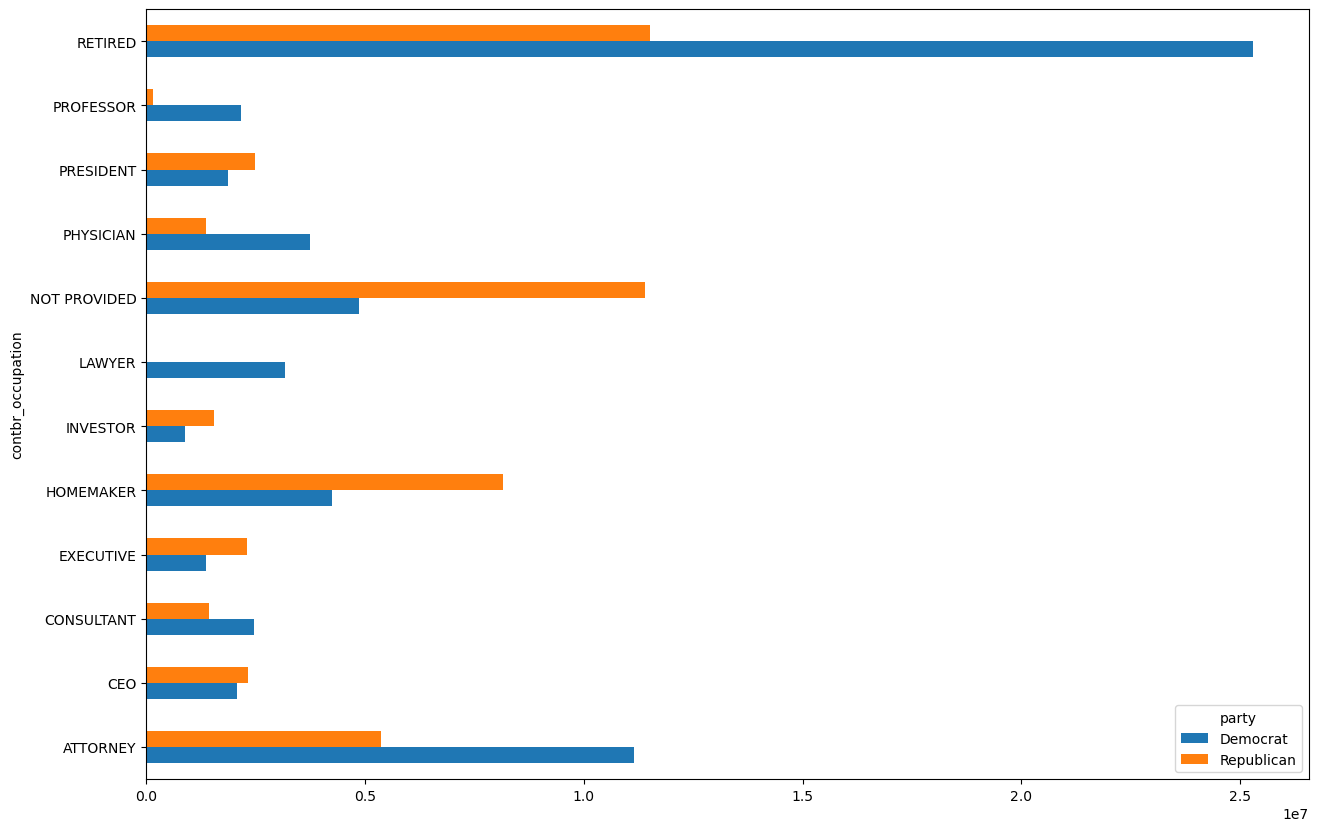

In [86]:
over_2mm.plot(kind='barh', figsize=(15,10) )

You might be interested in the top donor occupations or top companies donating to Obama and Romney. To do this, we can group by candidate name and use a variant of the top() method used earlier:

In [87]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()

    # Order totals by key in descending order
    return totals.sort_values(ascending=False)[:n]

In [88]:
grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

/tmp/ipykernel_46978/4235171140.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(get_top_amounts, 'contbr_occupation', n=7)


cand_nm        contbr_occupation
Obama, Barack  RETIRED              25305116.38
               ATTORNEY             11141982.97
               NOT PROVIDED          4866973.96
               HOMEMAKER             4248875.80
               PHYSICIAN             3735124.94
               LAWYER                3160478.87
               CONSULTANT            2459912.71
Romney, Mitt   RETIRED              11508473.59
               NOT PROVIDED         11396894.84
               HOMEMAKER             8147446.22
               ATTORNEY              5364718.82
               PRESIDENT             2491244.89
               CEO                   2324297.03
               EXECUTIVE             2300947.03
Name: contb_receipt_amt, dtype: float64

In [89]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

/tmp/ipykernel_46978/1241302789.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(get_top_amounts, 'contbr_employer', n=10)


cand_nm        contbr_employer   
Obama, Barack  RETIRED               22694358.85
               SELF-EMPLOYED         18626807.16
               NOT EMPLOYED           8586308.70
               NOT PROVIDED           5053480.37
               HOMEMAKER              2605408.54
               STUDENT                 318831.45
               VOLUNTEER               257104.00
               MICROSOFT               215585.36
               SIDLEY AUSTIN LLP       168254.00
               REFUSED                 149516.07
Romney, Mitt   NOT PROVIDED          12059527.24
               RETIRED               11506225.71
               HOMEMAKER              8147196.22
               SELF-EMPLOYED          7414115.22
               STUDENT                 496490.94
               CREDIT SUISSE           281150.00
               MORGAN STANLEY          267266.00
               GOLDMAN SACH & CO.      238250.00
               BARCLAYS CAPITAL        162750.00
               H.I.G. CAPITAL      

### Bucketing donation amounts

A useful way to analyze this data is to use the cut() function to discretize the contributor amounts into buckets by contribution size:

In [90]:
bins = np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)
labels.value_counts()

contb_receipt_amt
(10, 100]              404133
(100, 1000]            197348
(1000, 10000]           48470
(1, 10]                 43751
(0, 1]                    570
(1000000, 10000000]         4
(10000, 100000]             3
(100000, 1000000]           3
Name: count, dtype: int64

We can then group the data for Obama and Romney by name and bin label to get a histogram by donation size:

In [91]:
grouped = fec_mrbo.groupby(['cand_nm', labels])
grouped.size().unstack(0)

/tmp/ipykernel_46978/2972708327.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = fec_mrbo.groupby(['cand_nm', labels])


cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493,77
"(1, 10]",40070,3681
"(10, 100]",372280,31853
"(100, 1000]",153991,43357
"(1000, 10000]",22284,26186
"(10000, 100000]",2,1
"(100000, 1000000]",3,0
"(1000000, 10000000]",4,0


This data shows that Obama has received a significantly larger number of small donations than Romney. You can also sum the contribution amounts and normalize within buckets to visualize percentage of total donations of each size by candidate:

In [92]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)
bucket_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",318.24,77.00
"(1, 10]",337267.62,29819.66
"(10, 100]",20288981.41,1987783.76
"(100, 1000]",54798531.46,22363381.69
"(1000, 10000]",51753705.67,63942145.42
"(10000, 100000]",59100.00,12700.00
"(100000, 1000000]",1490683.08,0.00
"(1000000, 10000000]",7148839.76,0.00


And we can normalize these data to ease visualization:

In [93]:
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,0.000000
"(1000000, 10000000]",1.000000,0.000000


Or, graphically:

<Axes: ylabel='contb_receipt_amt'>

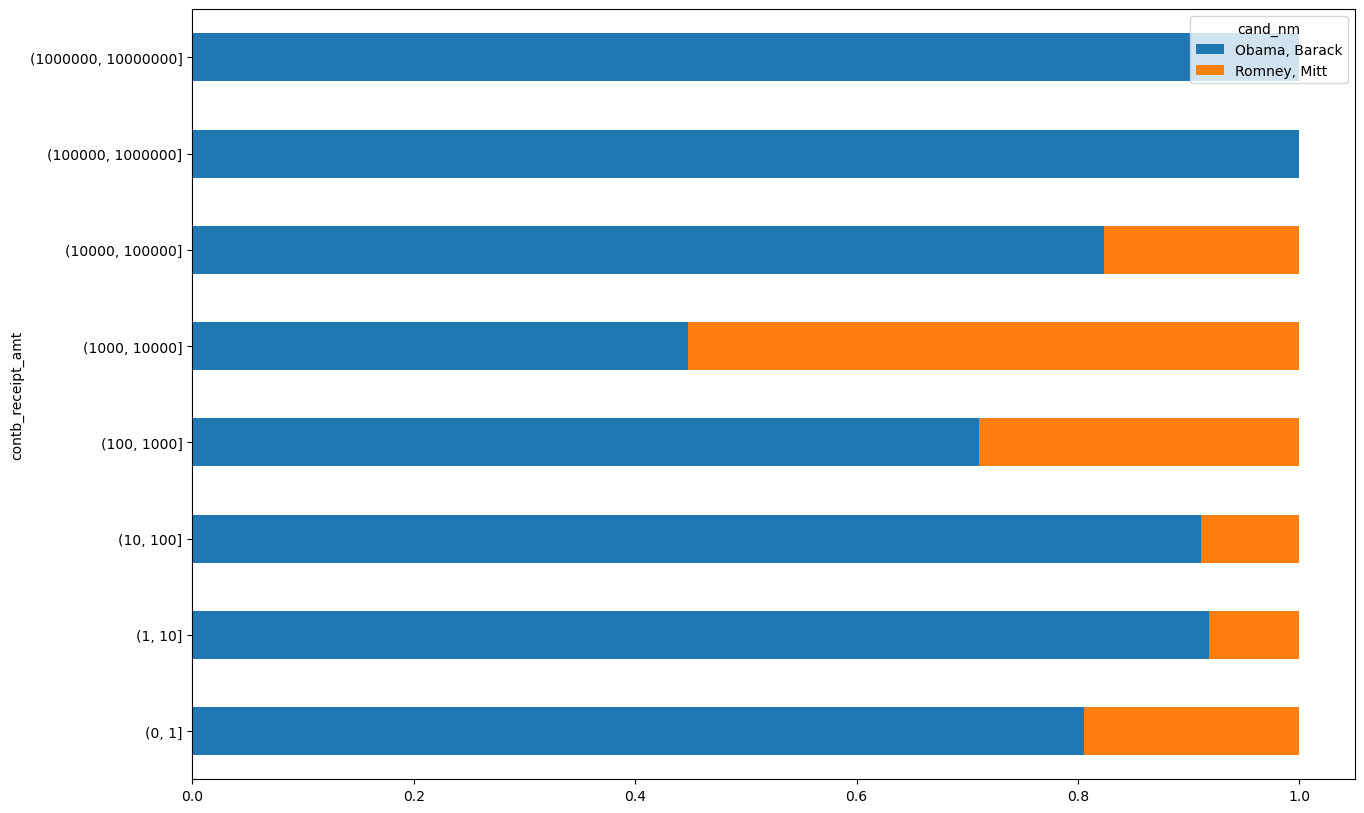

In [94]:
normed_sums.plot(kind='barh', stacked=True, figsize=(15,10) )

### Donation statistics by state

Aggregating the data by candidate and state is a routine affair:

In [95]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals = totals[totals.sum(1) > 100000]
totals.head()

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60


If we divide each row by the total contribution amount, you get the relative percentage of total donations by state for each candidate:

In [96]:
percent = totals.div(totals.sum(1), axis=0)
percent

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224
